# 20231128
sarahfong

Goal - compute the ddCT of gene expression for cells exposed to PEMF for 30' 60' 


**Key**
- qPCR technical replicates - qPCR was run twice for each technical replicate. 
- technical replicate - three cell samples were collected for each exposure
- noRT - amplification of primers without RT


In [72]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## load data

In [13]:
file = "qRT_PEMF.xlsx"

# read plates data
plate1 = pd.read_excel(file,sheet_name="Plate1")
plate2 = pd.read_excel(file,sheet_name="Plate2")

# add column annotating plate
plate1["plate"] = "plate1"
plate2["plate"] = "plate2"

## concatenate data together

In [14]:
# combine plate data into single dataframe
df = pd.concat([plate1, plate2])

## replace undetermined data w/ None

In [15]:
# HJL- whare are undetermined positions? 
# make a copy to reference what these positions are
undetermined = df.loc[df["CT"]=="Undetermined"].copy()  

# replace any missing values with None
df.loc[df["CT"]=="Undetermined", "CT"] = None

## qRT-PCR technical replicate means

In [18]:
means = df.groupby(['Gene', 'Sample_group', 'Replicate_w', "plate"])["CT"].mean().reset_index()
means

,Gene,Sample_group,Replicate_w,plate,CT
0,ACTB,1hr,1,plate1,26.767361
1,ACTB,1hr,1,plate2,24.729699
2,ACTB,1hr,2,plate1,26.843775
3,ACTB,1hr,2,plate2,24.875835
4,ACTB,1hr,3,plate1,26.969433
...,...,...,...,...,...
95,VEGF,30min,3,plate2,35.303993
96,VEGF,Control,1,plate2,35.451141
97,VEGF,Control,2,plate2,34.913185
98,VEGF,Control,3,plate2,38.738537


## compute delta CT 
(Gene A rep A - ACTB rep A), 

(Gene A rep B - ACTB rep B), 

In [22]:
# just focus on one plate to start. 
test = means.loc[means["plate"] == "plate1"].copy()
test.head()

,Gene,Sample_group,Replicate_w,plate,CT
0,ACTB,1hr,1,plate1,26.767361
2,ACTB,1hr,2,plate1,26.843775
4,ACTB,1hr,3,plate1,26.969433
6,ACTB,30min,1,plate1,26.507611
8,ACTB,30min,2,plate1,26.513749


In [56]:
table = pd.pivot(test, index =["Gene", "Replicate_w"], columns =['Sample_group'], values="CT").reset_index()

dct_tables = {}
for rep in np.arange(1,4):
    
    rep_table = table.loc[table["Replicate_w"] == rep].copy()

    # compute dCT as gene - ACTB per technical replicate, 
    cols = ["1hr", "30min", "Control"]
    for col in cols:

        # get ACTB control value
        ctrl = rep_table.loc[rep_table["Gene"]=='ACTB'][col].iloc[0]

        # compute delta CT as gene CT - ACTB CT per replicate
        rep_table[f"dct_{col}"] = rep_table[col] - ctrl
    dct_tables[rep] = rep_table
    

In [62]:
# make table w/ DCT values
table = pd.concat(dct_tables.values())
table

Sample_group,Gene,Replicate_w,1hr,30min,Control,noRT,dct_1hr,dct_30min,dct_Control
0,ACTB,1,26.767361,26.507611,26.63435,NaN,0.0,0.0,0.0
3,COL1A1,1,20.479109,23.304883,22.015965,NaN,-6.288252,-3.202728,-4.618385
6,HSP1A1,1,22.074978,22.650052,22.832475,28.38798,-4.692383,-3.857559,-3.801875
9,HSP70b,1,27.46653,28.44832,28.237463,28.767321,0.699169,1.940709,1.603113
12,HSP70c,1,23.363268,24.041624,24.368839,28.730185,-3.404093,-2.465987,-2.265511
1,ACTB,2,26.843775,26.513749,26.826961,NaN,0.0,0.0,0.0
4,COL1A1,2,21.96263,21.55629,21.945001,NaN,-4.881145,-4.957459,-4.88196
7,HSP1A1,2,22.459806,22.449149,22.760949,NaN,-4.383968,-4.0646,-4.066011
10,HSP70b,2,27.701744,27.968887,27.463682,NaN,0.857969,1.455138,0.636722
13,HSP70c,2,23.898009,24.345863,24.29302,NaN,-2.945765,-2.167886,-2.53394


## compute ddCT values

In [66]:
# get control dCT values only.
ctrls = table[["Gene", 'Replicate_w', 'dct_Control']].drop_duplicates().copy()
ctrls.groupby(["Gene"])['dct_Control'].mean().reset_index()

,Gene,dct_Control
0,ACTB,0.0
1,COL1A1,-4.646564
2,HSP1A1,-3.857319
3,HSP70b,1.249569
4,HSP70c,-2.272718


In [80]:
# HJL's approahc
df = plate1_mean

# Calculate average CT values for the control gene in each sample group
control_gene_avg = df[df['Gene'] == 'ACTB'].groupby('Sample_group')['CT'].mean().reset_index()
control_gene_avg.rename(columns={'CT': 'Control_mean'}, inplace=True)

# Merge control gene average values back to the main DataFrame
df = pd.merge(df, control_gene_avg, on='Sample_group', how='left')

# Calculate dCT by subtracting the CT value from the control gene's average CT value
df['dCT'] = df['CT'] - df['Control_mean']

# Calculate average dCT values for the control samples for each gene
control_gene_dCT_avg = df[df['Sample_group'] == 'Control'].groupby(['Gene'])['dCT'].mean().reset_index()
control_gene_dCT_avg.rename(columns={'dCT': 'Control_dCT_mean'}, inplace=True)

# Merge control group average dCT values back to the main DataFrame for each gene
df = pd.merge(df, control_gene_dCT_avg, on='Gene', how='left')

# Calculate ddCT by subtracting the average dCT of control samples for each gene from the dCT value
df['ddCT'] = df['dCT'] - df['Control_dCT_mean']

# Assuming 'df' contains the 'ddCT' values for each gene

# Calculate fold change using the formula 2^(-ddCT)
df['fold_change'] = 2 ** (-df['ddCT'])

# Save to Excel or perform further operations as needed
df.to_excel('plate1_output.xlsx', index=False)


NameError: name 'plate1_mean' is not defined

/Users/hjl/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


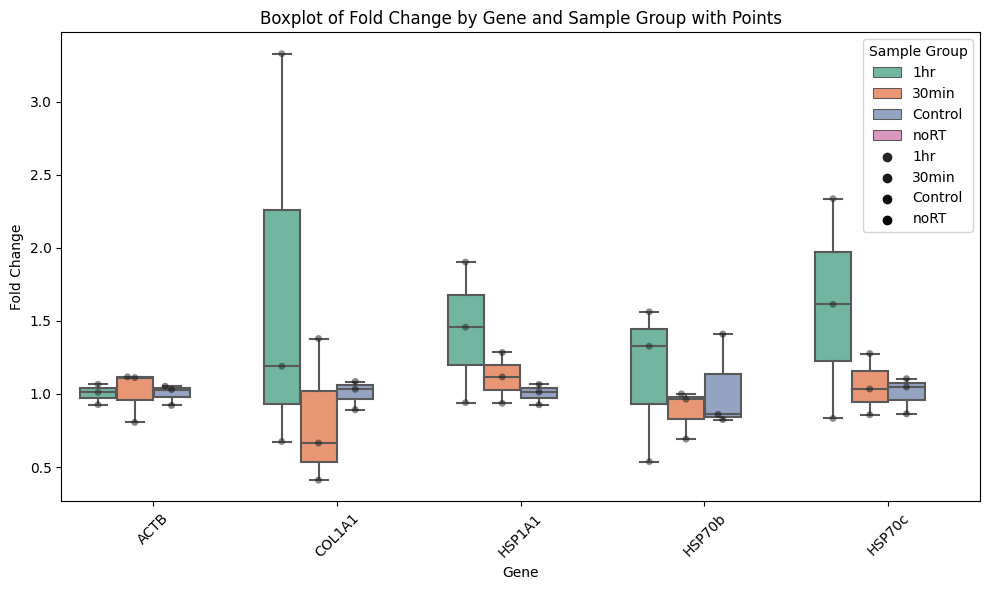

In [9]:


# Assuming 'df' contains the 'fold_change' values, and you want to create a boxplot with points

# Set up the boxplot and swarmplot using Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Gene', y='fold_change', hue='Sample_group', palette='Set2', showfliers=False)
sns.swarmplot(data=df, x='Gene', y='fold_change', hue='Sample_group', dodge=True, color='black', alpha=0.5)
plt.xlabel('Gene')
plt.ylabel('Fold Change')
plt.title('Boxplot of Fold Change by Gene and Sample Group with Points')
plt.legend(title='Sample Group')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()
